This notebook contains other pandas functionality that was not covered in the course, but that I have found useful in other cases

In [1]:
import os
import pandas as pd
import jupyter_black

jupyter_black.load()

current_dir = os.path.dirname(os.path.abspath("__file__"))

### Set file path to datasets

In [2]:
pokemon_path = os.path.join(current_dir, "data", "pokemon.csv")
google_path = os.path.join(current_dir, "data", "google_stock_price.csv")
nba_path = os.path.join(current_dir, "data", "nba.csv")
revenue_path = os.path.join(current_dir, "data", "revenue.csv")
bond_path = os.path.join(current_dir, "data", "jamesbond.csv")
chicago_path = os.path.join(current_dir, "data", "chicago.csv")
salesmen_path = os.path.join(current_dir, "data", "salesmen.csv")
foods_path = os.path.join(current_dir, "data", "foods.csv")

,Open,High,Low,Close,Volume
Date,,,,,
2023-03-09,153.559,154.5350,150.225,150.59,53833582.0
2023-03-08,152.810,153.4700,151.830,152.87,47204791.0
2023-03-07,153.700,154.0299,151.130,151.60,56182028.0


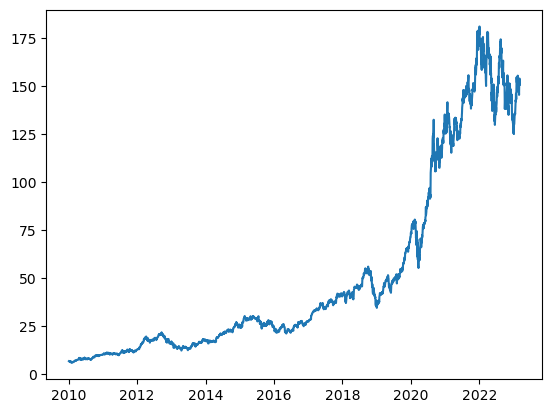

In [4]:
from pandas_datareader import data
import matplotlib.pyplot as plt

stocks = data.DataReader(
    name="AAPL", data_source="stooq", start="2010-01-01", end="2023-03-09"
)

display(stocks.head(3))

x = stocks.index
y = stocks.Close
plt.plot(x, y)
plt.show()

### The `.applymap()` method

This method applies a function that accepts and returns a scalar to every element of a DataFrame.

In [7]:
stocks.applymap(lambda cell: cell > 151)

,Open,High,Low,Close,Volume
Date,,,,,
2023-03-09,True,True,False,False,True
2023-03-08,True,True,True,True,True
2023-03-07,True,True,True,True,True
2023-03-06,True,True,True,True,True
2023-03-03,False,True,False,True,True
...,...,...,...,...,...
2010-01-08,False,False,False,False,True
2010-01-07,False,False,False,False,True
2010-01-06,False,False,False,False,True
